### FFT Plots Myobock

This script performs a Fast Fourier Transformation (FFT) to plot Myobock EMG Signals in the Frequency Domain.

[INFO] Loading Raw Unfiltered Data...


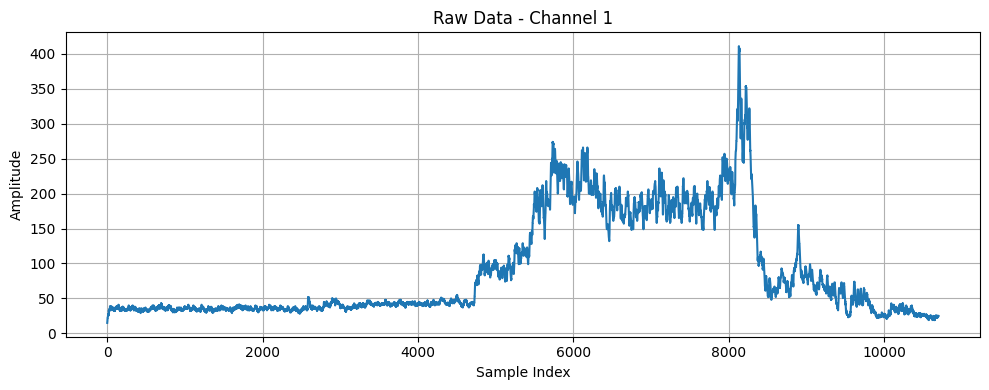

[INFO] Loading Highpass Filtered from highpass_filtered.npy...
[INFO] Loading Rectified Signals from rectified_signals.npy...
[INFO] Loading Smoothed Signals from smoothed_signals.npy...
[INFO] Loading Normalized EMG Envelope from normalized_envelope.npy...
[INFO] Computing FFT for Raw Unfiltered (Trimmed)...
[INFO] Computing FFT for Highpass Filtered...
[INFO] Computing FFT for Rectified Signals...
[INFO] Computing FFT for Smoothed Signals...
[INFO] Computing FFT for Normalized EMG Envelope...


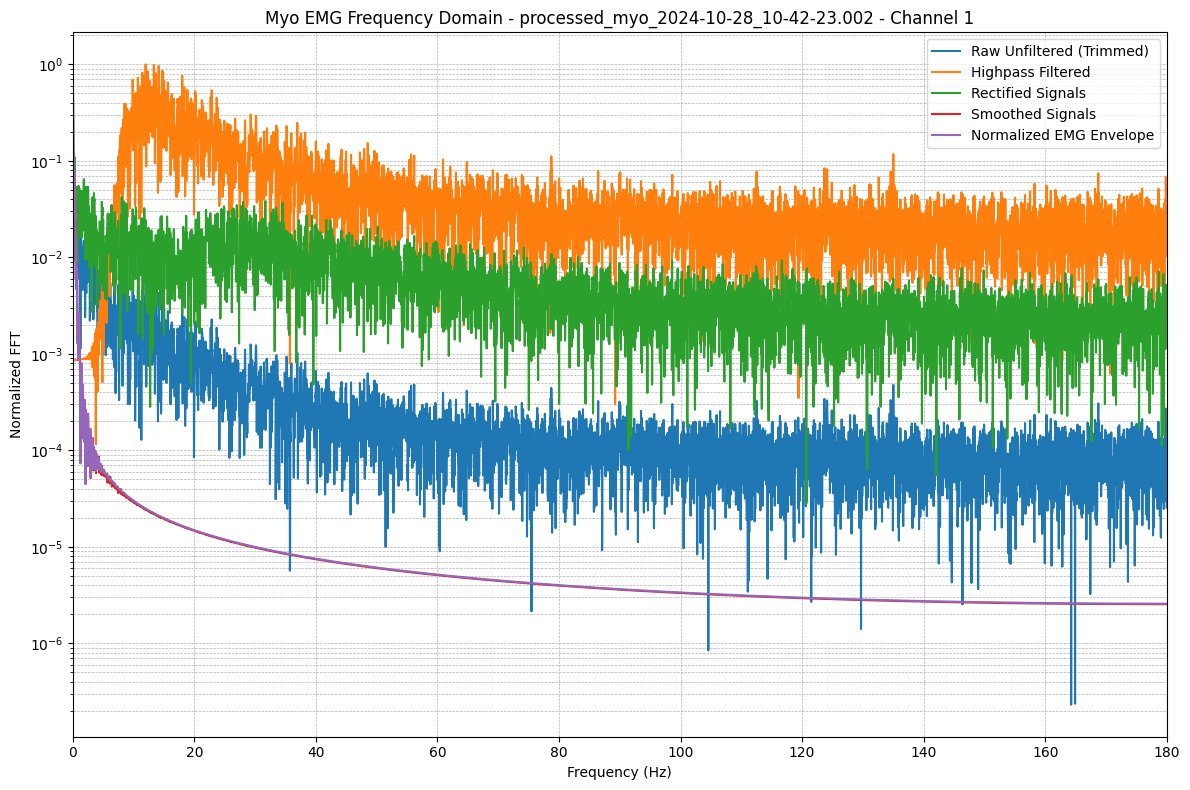

[INFO] Frequency domain plot saved to C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(1)\Processed EMG Data\Processed Myo\processed_myo_2024-10-28_10-42-23.002_myo_frequency_domain_channel_1.png for Channel 1


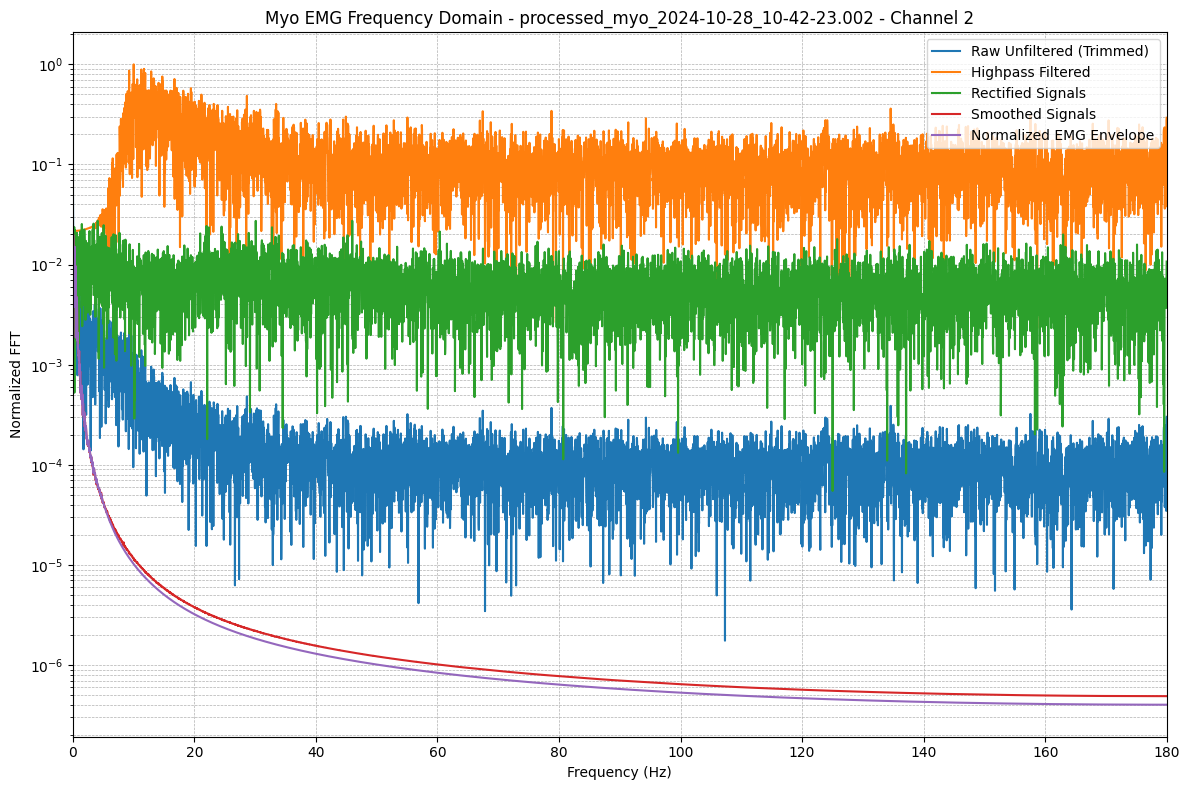

[INFO] Frequency domain plot saved to C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(1)\Processed EMG Data\Processed Myo\processed_myo_2024-10-28_10-42-23.002_myo_frequency_domain_channel_2.png for Channel 2


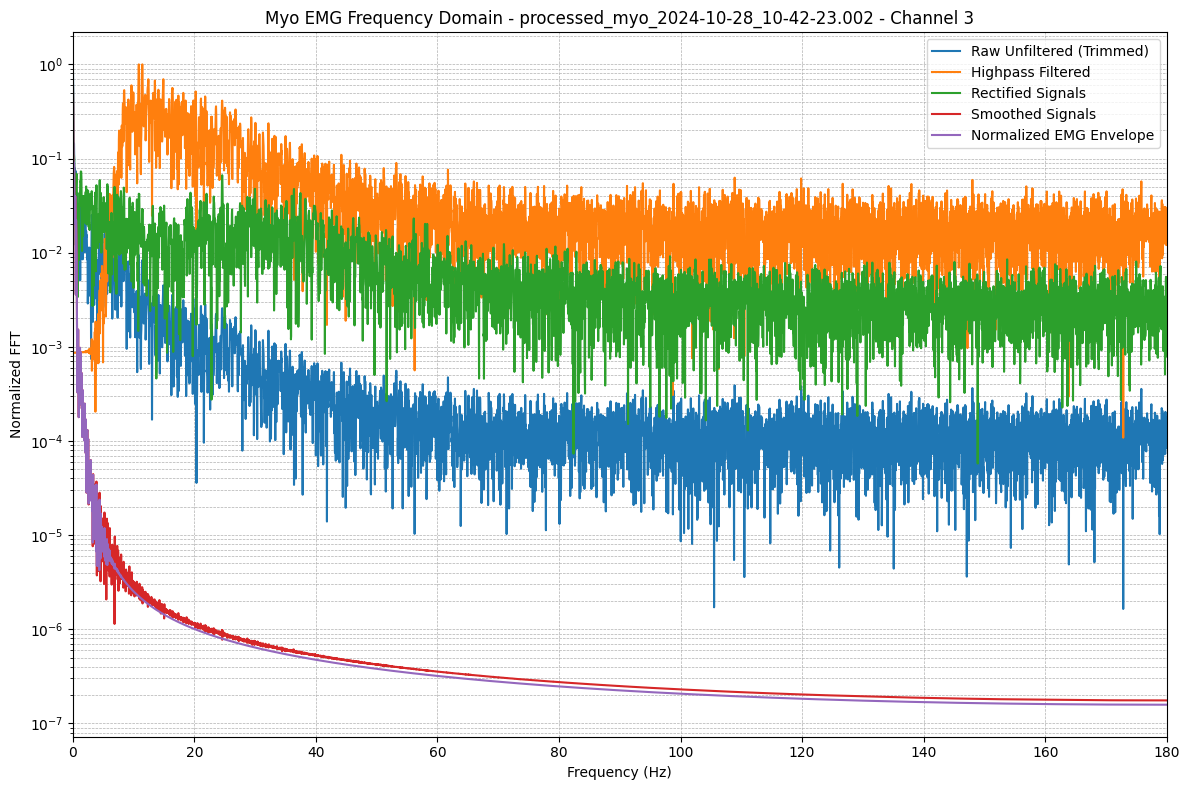

[INFO] Frequency domain plot saved to C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(1)\Processed EMG Data\Processed Myo\processed_myo_2024-10-28_10-42-23.002_myo_frequency_domain_channel_3.png for Channel 3


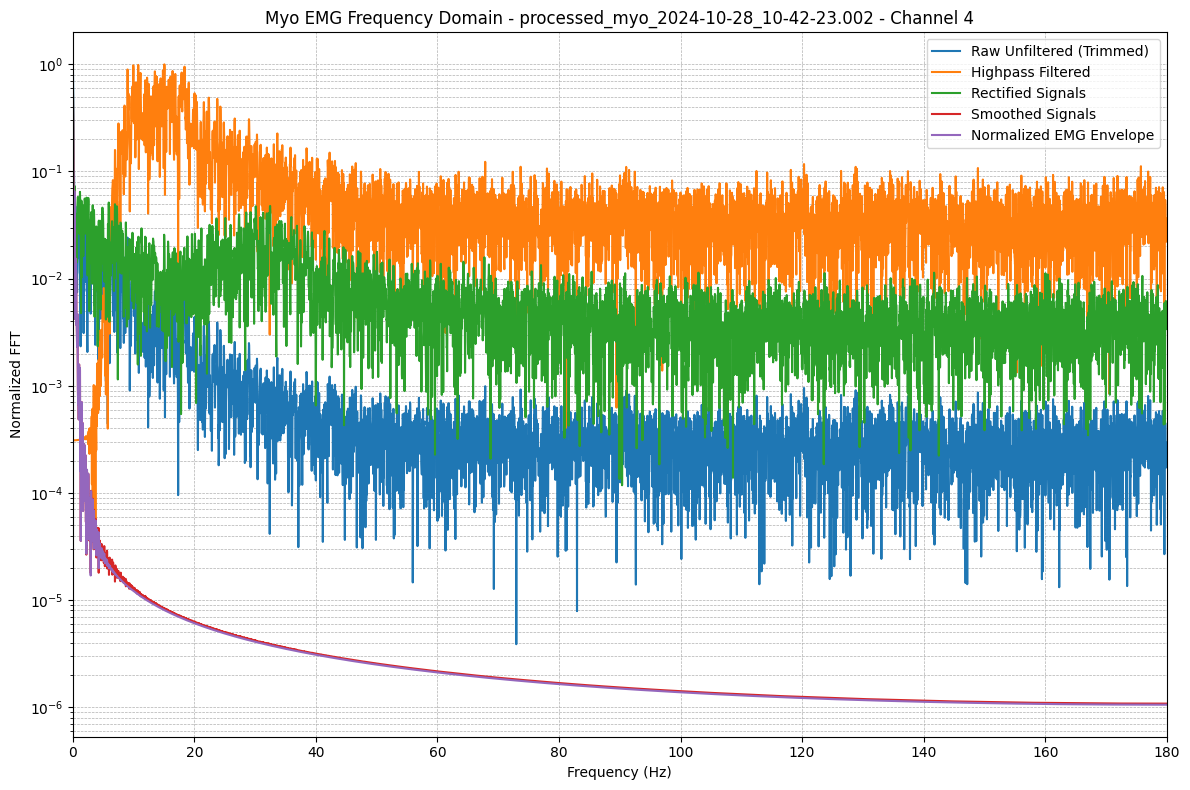

[INFO] Frequency domain plot saved to C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(1)\Processed EMG Data\Processed Myo\processed_myo_2024-10-28_10-42-23.002_myo_frequency_domain_channel_4.png for Channel 4


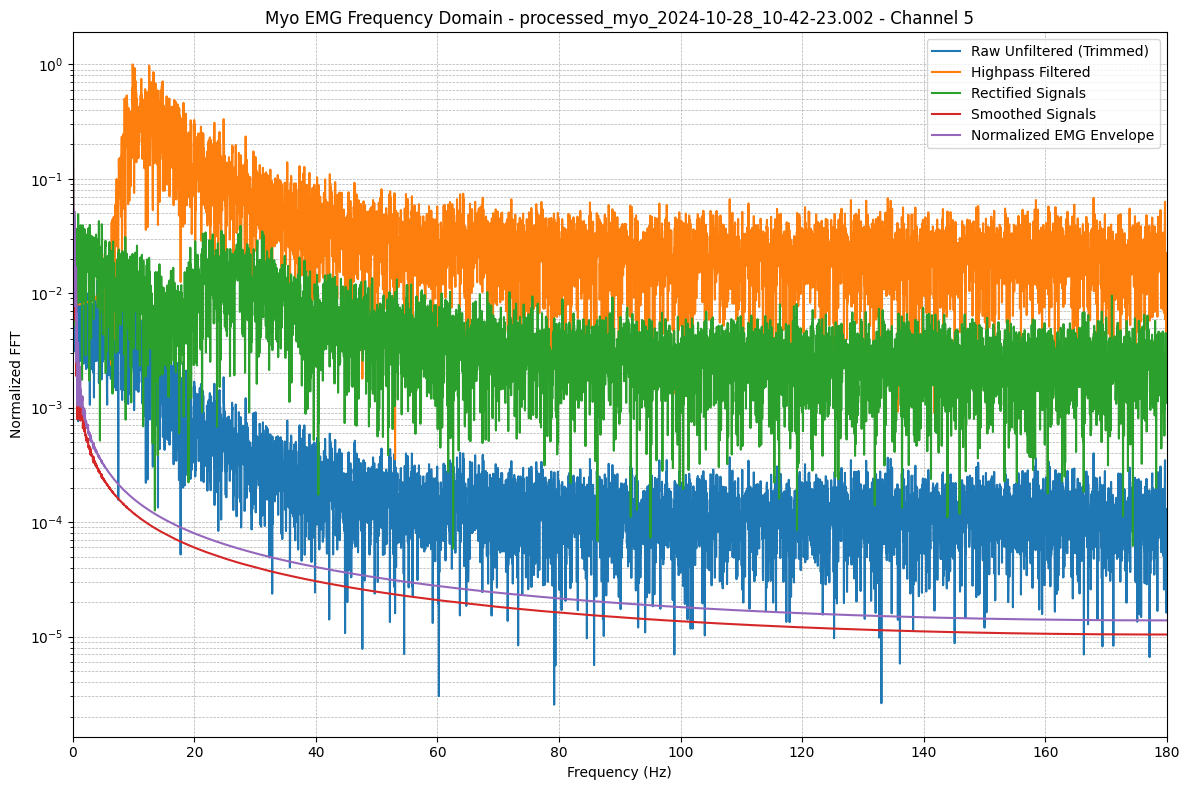

[INFO] Frequency domain plot saved to C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data\P(1)\Processed EMG Data\Processed Myo\processed_myo_2024-10-28_10-42-23.002_myo_frequency_domain_channel_5.png for Channel 5
[INFO] All channel plots have been generated and saved.


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

def plot_myo_frequency_steps_single_file(raw_csv_path, processed_folder, processed_filename_base, fs=360,
                                         use_log_scale=True, normalize=False, trim_duration=0.2):
    """
    Plot the frequency domain representations of all processing steps for Myo EMG signals,
    with separate subplots for each of the five channels.

    Processing Steps to Plot:
    1. Raw Unfiltered (Trimmed)
    2. Highpass Filtered
    3. Rectified Signals
    4. Smoothed Signals
    5. Normalized EMG Envelope
    """

    # Map step names to the suffixes used in the .npy files
    processed_types = {
        'Raw Unfiltered (Trimmed)': None,
        'Highpass Filtered': 'highpass_filtered',
        'Rectified Signals': 'rectified_signals',
        'Smoothed Signals': 'smoothed_signals',
        'Normalized EMG Envelope': 'normalized_envelope'
    }

    signals = {}

    # 1. Load Raw CSV and Trim
    try:
        print("[INFO] Loading Raw Unfiltered Data...")
        # Corrected: Skip initial header rows and select first 5 columns
        raw_data = pd.read_csv(raw_csv_path, delimiter=',', header=None, skiprows=2).iloc[:, :5].to_numpy()
        plt.figure(figsize=(10, 4))
        plt.plot(raw_data[:, 0])
        plt.title("Raw Data - Channel 1")
        plt.xlabel("Sample Index")
        plt.ylabel("Amplitude")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        trim_samples = int(trim_duration * fs)
        if raw_data.shape[0] <= trim_samples:
            print("[WARNING] Raw data has fewer samples than the trim duration. Skipping.")
            return
        raw_data = raw_data[trim_samples:, :]  # Trim from the start
        signals['Raw Unfiltered (Trimmed)'] = raw_data  # Shape: (samples, channels)
    except Exception as e:
        print(f"[ERROR] Failed to load raw data: {e}")
        return

    # 2. Load Processed Data
    for step_name, suffix in processed_types.items():
        if step_name == 'Raw Unfiltered (Trimmed)':
            continue  # already handled

        file_suffix = f"{suffix}.npy"
        file_path = os.path.join(processed_folder, f"{processed_filename_base}_{file_suffix}")
        if not os.path.exists(file_path):
            print(f"[WARNING] File not found for {step_name}: {file_path}. Skipping.")
            continue

        try:
            print(f"[INFO] Loading {step_name} from {file_suffix}...")
            data = np.load(file_path)  # Expecting shape (samples, channels)
            signals[step_name] = data
        except Exception as e:
            print(f"[ERROR] Failed to load {step_name}: {e}")
            continue

    if not signals:
        print("[WARNING] No signals loaded. Exiting.")
        return

    # Ensure consistent length for FFT
    min_samples = min(sig.shape[0] for sig in signals.values())
    for key in signals:
        signals[key] = signals[key][:min_samples, :]  # Trim to min_samples

    # Compute FFT for each processing step and each channel
    fft_results = {}
    freqs = np.fft.rfftfreq(min_samples, d=1/fs)

    for step_name, data in signals.items():
        print(f"[INFO] Computing FFT for {step_name}...")
        # Compute FFT along the time axis (axis=0)
        fft_magnitude = np.abs(np.fft.rfft(data, axis=0))  # Shape: (freq_bins, channels)
        
        if normalize:
            # Normalize each channel separately
            fft_magnitude /= np.max(fft_magnitude, axis=0, keepdims=True) + 1e-10  # Avoid division by zero

        fft_results[step_name] = fft_magnitude  # Shape: (freq_bins, channels)

    # Plotting: Create separate subplots for each channel
    num_channels = signals['Raw Unfiltered (Trimmed)'].shape[1]
    processing_steps = list(processed_types.keys())

    for channel in range(num_channels):
        plt.figure(figsize=(12, 8))
        for step_name in processed_types.keys():
            if step_name not in fft_results:
                continue
            fft_magnitude = fft_results[step_name][:, channel]
            if use_log_scale:
                plt.semilogy(freqs, fft_magnitude, label=step_name)
            else:
                plt.plot(freqs, fft_magnitude, label=step_name)
        
        plt.title(f"Myo EMG Frequency Domain - {processed_filename_base} - Channel {channel + 1}")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Normalized FFT" if normalize else "FFT Magnitude")
        plt.xlim(0, fs / 2)
        plt.legend()
        plt.grid(True, linestyle='--', linewidth=0.5, which='both')
        plt.tight_layout()

        plot_filename = f"{processed_filename_base}_myo_frequency_domain_channel_{channel + 1}.png"
        plot_path = os.path.join(processed_folder, plot_filename)
        plt.savefig(plot_path)
        plt.show()
        print(f"[INFO] Frequency domain plot saved to {plot_path} for Channel {channel + 1}")

    print("[INFO] All channel plots have been generated and saved.")

# ------------------------------------------------------
# Example for Myo Participant 1
# ------------------------------------------------------
if __name__ == "__main__":
    # Replace with your participant ID or remove if not needed
    participant = 1

    # Base path to your data
    base_path = r"C:\Users\schmi\Documents\Studium\TUM\5. Semester\Masterthesis\Experimental Data"
    participant_folder = os.path.join(base_path, f"P({participant})")

    myo_raw_filename = "sensor_data_2024-10-28_10-42-23.002.csv"
    raw_csv_path = os.path.join(participant_folder, "Myo", myo_raw_filename)

    # Adjust processed base name: replace "sensor_data" with "myo" in the file stem
    myo_raw_stem = os.path.splitext(myo_raw_filename)[0]
    myo_processed_stem = myo_raw_stem.replace("sensor_data", "myo")
    processed_filename_base = f"processed_{myo_processed_stem}"

    # The processed files are assumed to be in 'Processed EMG Data\Processed Myo'
    processed_folder = os.path.join(participant_folder, "Processed EMG Data", "Processed Myo")

    # Call the plotting function with corrected parameters
    plot_myo_frequency_steps_single_file(
        raw_csv_path=raw_csv_path,
        processed_folder=processed_folder,
        processed_filename_base=processed_filename_base,
        fs=360,  # Updated to match the second script's sampling frequency
        use_log_scale=True,
        normalize=True,
        trim_duration=0.2
    )
